In [1]:
# step1
import pandas as pd
df = pd.read_csv('pre_24_merged_30_rows_12_07.csv')
# Assuming your DataFrame is named df
df['charttime'] = pd.to_datetime(df['charttime'])  # Convert to datetime if not already
df.sort_values(['stay_id', 'charttime'], inplace=True)  # Sort by stay_id and charttime

# Calculate the 'before_weaning_hr' column
df['before_weaning_hr'] = df.groupby('stay_id').cumcount(ascending=False)

# Resetting index (optional)
df.reset_index(drop=True, inplace=True)

# transform the (type is object) column to one hot encoding
cols_need_one_hot_encoding = ['gender', 'race','admission_type', 'first_careunit', 'insurance', 'ventilator_mode_group']
one_hot_encoding = pd.get_dummies(df[cols_need_one_hot_encoding])
df_with_one_hot_encoding = df.join(one_hot_encoding) # df.join default index-on-index
df_with_one_hot_encoding


subject_id   stay_id   hadm_id           charttime  before_weaning_hr  \
0        14569364  30005707  20870580 2144-01-11 20:00:00                 23   
1        14569364  30005707  20870580 2144-01-11 21:00:00                 22   
2        14569364  30005707  20870580 2144-01-11 22:00:00                 21   
3        14569364  30005707  20870580 2144-01-11 23:00:00                 20   
4        14569364  30005707  20870580 2144-01-12 00:00:00                 19   
...           ...       ...       ...                 ...                ...   
63907    11539827  39995735  21192405 2124-08-21 05:00:00                  4   
63908    11539827  39995735  21192405 2124-08-21 06:00:00                  3   
63909    11539827  39995735  21192405 2124-08-21 07:00:00                  2   
63910    11539827  39995735  21192405 2124-08-21 08:00:00                  1   
63911    11539827  39995735  21192405 2124-08-21 09:00:00                  0   

       age_now gender insurance   race  \
0           83      M  Medicare  WHITE   
1           83      M  Medicare  WHITE   
2           83      M  Medicare  WHITE   
3           83      M  Medicare  WHITE   
4           83      M  Medicare  WHITE   
...        ...    ...       ...    ...   
63907       62      M     Other  WHITE   
63908       62      M     Other  WHITE   
63909       62      M     Other  WHITE   
63910       62      M     Other  WHITE   
63911       62      M     Other  WHITE   

                                     first_careunit  ...  \
0               Surgical Intensive Care Unit (SICU)  ...   
1               Surgical Intensive Care Unit (SICU)  ...   
2               Surgical Intensive Care Unit (SICU)  ...   
3               Surgical Intensive Care Unit (SICU)  ...   
4               Surgical Intensive Care Unit (SICU)  ...   
...                                             ...  ...   
63907  Cardiac Vascular Intensive Care Unit (CVICU)  ...   
63908  Cardiac Vascular Intensive Care Unit (CVICU)  ...   
63909  Cardiac Vascular Intensive Care Unit (CVICU)  ...   
63910  Cardiac Vascular Intensive Care Unit (CVICU)  ...   
63911  Cardiac Vascular Intensive Care Unit (CVICU)  ...   

      first_careunit_Neuro Intermediate  \
0                                 False   
1                                 False   
2                                 False   
3                                 False   
4                                 False   
...                                 ...   
63907                             False   
63908                             False   
63909                             False   
63910                             False   
63911                             False   

       first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)  \
0                                                  False                
1                                                  False                
2                                                  False                
3                                                  False                
4                                                  False                
...                                                  ...                
63907                                              False                
63908                                              False                
63909                                              False                
63910                                              False                
63911                                              False                

       first_careunit_Surgical Intensive Care Unit (SICU)  \
0                                                   True    
1                                                   True    
2                                                   True    
3                                                   True    
4                                                   True    
...                                                  ...    

In [2]:
# step2
# import
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GroupShuffleSplit # used to separated data
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
# draw decision tree
from io import StringIO
import numpy as np
from sklearn import tree
import pydotplus
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt
from IPython.display import Image
import graphviz

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# step3
# split data
# drop type which is not float or not int
df_with_one_hot_encoding_drop_not_num = df_with_one_hot_encoding.drop(['subject_id', 'hadm_id', 'ventilator_mode'], axis=1) # 'stay_id', 
df_with_one_hot_encoding_drop_not_num = df_with_one_hot_encoding_drop_not_num.drop(['charttime',  'gender', 'race','admission_type', 'first_careunit', 'insurance', 'ventilator_mode_group'], axis=1)

# the before_weaning_hr we want
print_before_weaning_hr = 365
#df_with_one_hot_encoding_drop_not_num = df_with_one_hot_encoding_drop_not_num[df_with_one_hot_encoding_drop_not_num['before_weaning_hr']==print_before_weaning_hr]
#df_with_one_hot_encoding_drop_not_num.drop(['before_weaning_hr'], axis=1, inplace=True)

y = df_with_one_hot_encoding_drop_not_num['label']
X = df_with_one_hot_encoding_drop_not_num.drop(['label'], axis=1)

"""
stayid = df_with_one_hot_encoding_drop_not_num['stay_id']
stayid = stayid.drop_duplicates()
np.random.seed(42) # add seed
permu_stayid = np.random.permutation(stayid)

# split 0.6, 0.2, 0.2
num_patient =  len(permu_stayid)
train_stayid, validation_stayid, test_stayid = np.split(permu_stayid, [int(num_patient*0.6), int(num_patient*0.8)])
train_stayid, validation_stayid, test_stayid = pd.Series(train_stayid, name='stay_id'), pd.Series(validation_stayid, name='stay_id'), pd.Series(test_stayid, name='stay_id')
"""

# train, validation, test : 1859, 273, 528
train_stayid = pd.read_csv('train_data_id.csv')
validation_stayid = pd.read_csv('val_data_id.csv')
test_stayid = pd.read_csv('test_data_id.csv')

train_stayid.columns = ['stay_id']
validation_stayid.columns = ['stay_id']
test_stayid.columns = ['stay_id']

print("train", len(train_stayid)) # 1859
print("val", len(validation_stayid)) # 273
print("test", len(test_stayid)) # 528

train = pd.merge(train_stayid, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
validation = pd.merge(validation_stayid, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
test = pd.merge(test_stayid, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
train_X = train.drop(['label', 'stay_id'], axis=1)
validation_X = validation.drop(['label', 'stay_id'], axis=1)
test_X = test.drop(['label', 'stay_id'], axis=1)
train_y = train['label']
validation_y = validation['label']
test_y = test['label']



#"""test
merge_tr_v = pd.merge(train_stayid, validation_stayid, on=['stay_id'], how='inner')
merge_v_te = pd.merge(validation_stayid, test_stayid, on=['stay_id'], how='inner')
merge_te_tr = pd.merge(test_stayid, train_stayid, on=['stay_id'], how='inner')
print("merge", merge_tr_v, merge_v_te, merge_te_tr)
union_stayid_tr_v = pd.concat([train_stayid, validation_stayid])
tr_v = pd.merge(union_stayid_tr_v, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
tr_v_X = tr_v.drop(['label', 'stay_id'], axis=1)
tr_v_y = tr_v['label']
#testend"""
print(tr_v_X.columns)
print("tr_v", len(tr_v)) #2132

"""
# add
# Z-score
from sklearn import preprocessing
train_X = preprocessing.scale(train_X)
validation_X = preprocessing.scale(validation_X)
test_X = preprocessing.scale(test_X)
# addend
"""

train 1859
val 273
test 528
merge Empty DataFrame
Columns: [stay_id]
Index: [] Empty DataFrame
Columns: [stay_id]
Index: [] Empty DataFrame
Columns: [stay_id]
Index: []
Index(['before_weaning_hr', 'age_now', 'weight_kg', 'height_cm', 'tobacco',
       'RSBI', 'minute_ventilation', 'peep', 'fio2', 'tidal_volume_observed',
       'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp',
       'mbp', 'resp_rate', 'spo2', 'gender_F', 'gender_M',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN',
       'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN',
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',
       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
       'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - DOMINICAN',
       'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - HONDURAN

'\n# add\n# Z-score\nfrom sklearn import preprocessing\ntrain_X = preprocessing.scale(train_X)\nvalidation_X = preprocessing.scale(validation_X)\ntest_X = preprocessing.scale(test_X)\n# addend\n'

In [11]:
# step4.0.0
# accuracy function
from sklearn import metrics
from sklearn.metrics import classification_report

def acc_function(Model, test_X, test_y):
    # 使用訓練資料預測
    predicted_test_y=Model.predict(test_X)
    # sensitivity
    recall = metrics.recall_score(test_y, predicted_test_y)
    print("sensitivity=recall=", recall)
    # specificity
    confusion_matrix = metrics.confusion_matrix(test_y, predicted_test_y)
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    specificity = (TN / float(TN+FP))
    print("specificity", specificity)
    # confusion_matrix
    print("confusion_matrix\n", confusion_matrix)
    # accuracy_score
    test_accuracy = accuracy_score(test_y, predicted_test_y)
    print("accuracy_score", test_accuracy)
    # ROC curve 
    print("ROC curve")
    fpr, tpr, thershold = metrics.roc_curve(test_y, Model.predict_proba(test_X)[:, 1])
    roc_auc = metrics.auc(fpr, tpr) # auroc
    print("roc_auc", roc_auc)
    plt.plot(fpr, tpr, label='ROC area ='+str(roc_auc))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print('c_r')
    target_names = ['class 0', 'class 1']
    print(classification_report(test_y, predicted_test_y, target_names=target_names))

In [7]:
# step4.0.1
# feature importance
from sklearn.inspection import permutation_importance

def feature_importance(model, X, y):
    perm_importance = permutation_importance(model, X, y)
    perm_importance_normalized = perm_importance.importances_mean/perm_importance.importances_mean.sum()
    # feature's name
    feature_name = X.columns
    feature_name = np.array(feature_name)
    sorted_idx = perm_importance_normalized.argsort()
    # plot
    plt.figure(figsize=(8, 20))
    plt.title('feature importance', fontsize=20)
    plt.barh(feature_name[sorted_idx], perm_importance_normalized[sorted_idx], color='r', align='center')
    plt.xlabel('relative importance', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    for index, value in enumerate(perm_importance_normalized[sorted_idx]):
        plt.text(value, index,
                 str(round(value,2)), fontsize=15)
    
    plt.show()

In [ ]:
# step4 decision tree

print("before weaning hour =", print_before_weaning_hr)

# GridSearchCV
from sklearn.model_selection import GridSearchCV
Model = DecisionTreeClassifier() #(n_estimators=tree_num, criterion='gini', max_depth=10, min_samples_split=5)
param_grid = {'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':np.arange(1, 20), 'min_samples_split':np.arange(2, 6), 'min_samples_leaf':np.arange(1, 5), 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='accuracy', error_score='raise')
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
decisionTreeModel = grid_search.best_estimator_
#decisionTreeModel = Model.fit(tr_v_X, tr_v_y)
# 使用訓練資料訓練模型
"""

# 使用訓練資料預測
# accuracy for train
print("train")
acc_function(decisionTreeModel, train_X, train_y)

# accuracy for validation
print("validation")
acc_function(decisionTreeModel, validation_X, validation_y)
"""
"""
# accuracy for tr&v
print("train & v")
acc_function(decisionTreeModel, tr_v_X, tr_v_y)
"""
# accuracy for test
print("test")
acc_function(decisionTreeModel, test_X, test_y)

io = StringIO()
tree.export_graphviz(decisionTreeModel, feature_names=(X.drop(['stay_id'], axis=1)).columns, max_depth=3, out_file=io, class_names=np.array(train_y.unique()).astype('str').tolist(), filled=True)
graph_tree = pydotplus.graph_from_dot_data(io.getvalue())
graph_tree.write_png("decision tree")
img_tree = mpl_image.imread("decision tree")
#plt.figure(figsize=(200, 450))
#plt.show(img_tree)
Image(graph_tree.create_png())


using (train and validation) to compute feature_importance


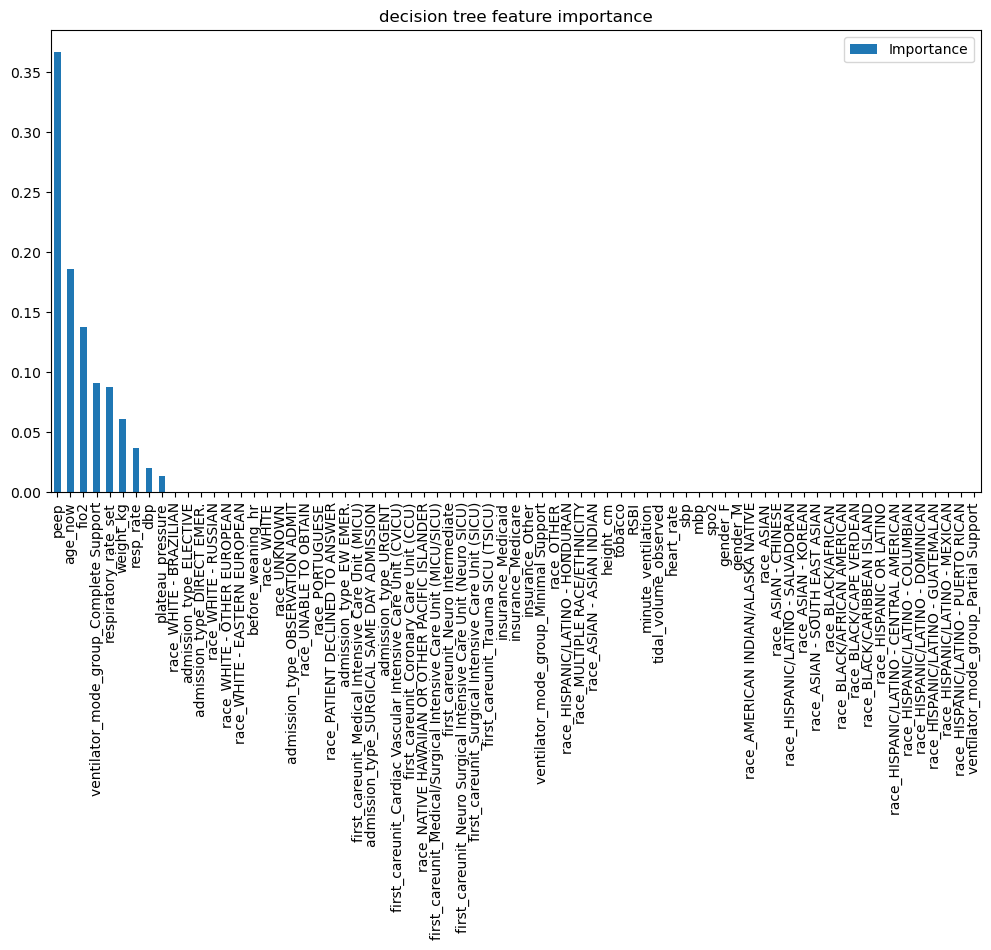

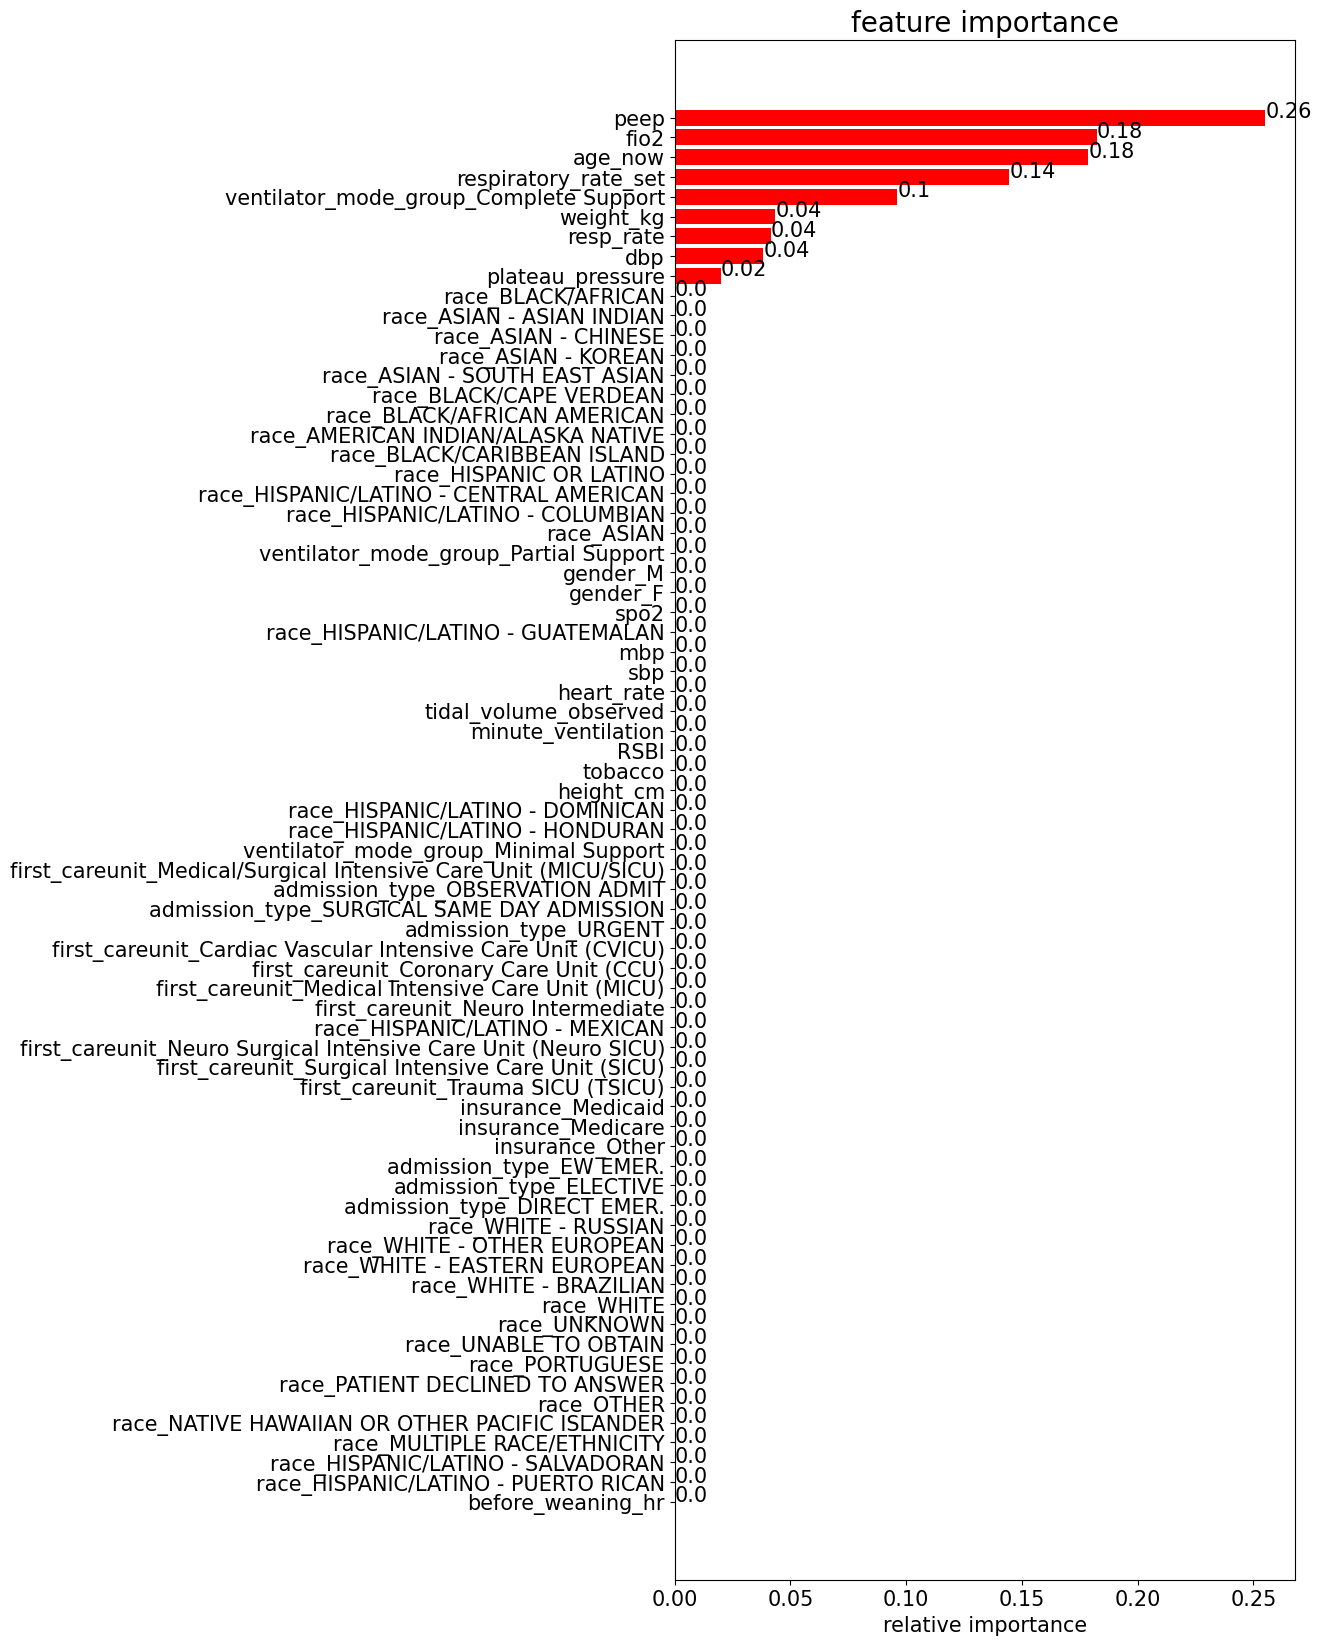

using test to compute feature_importance


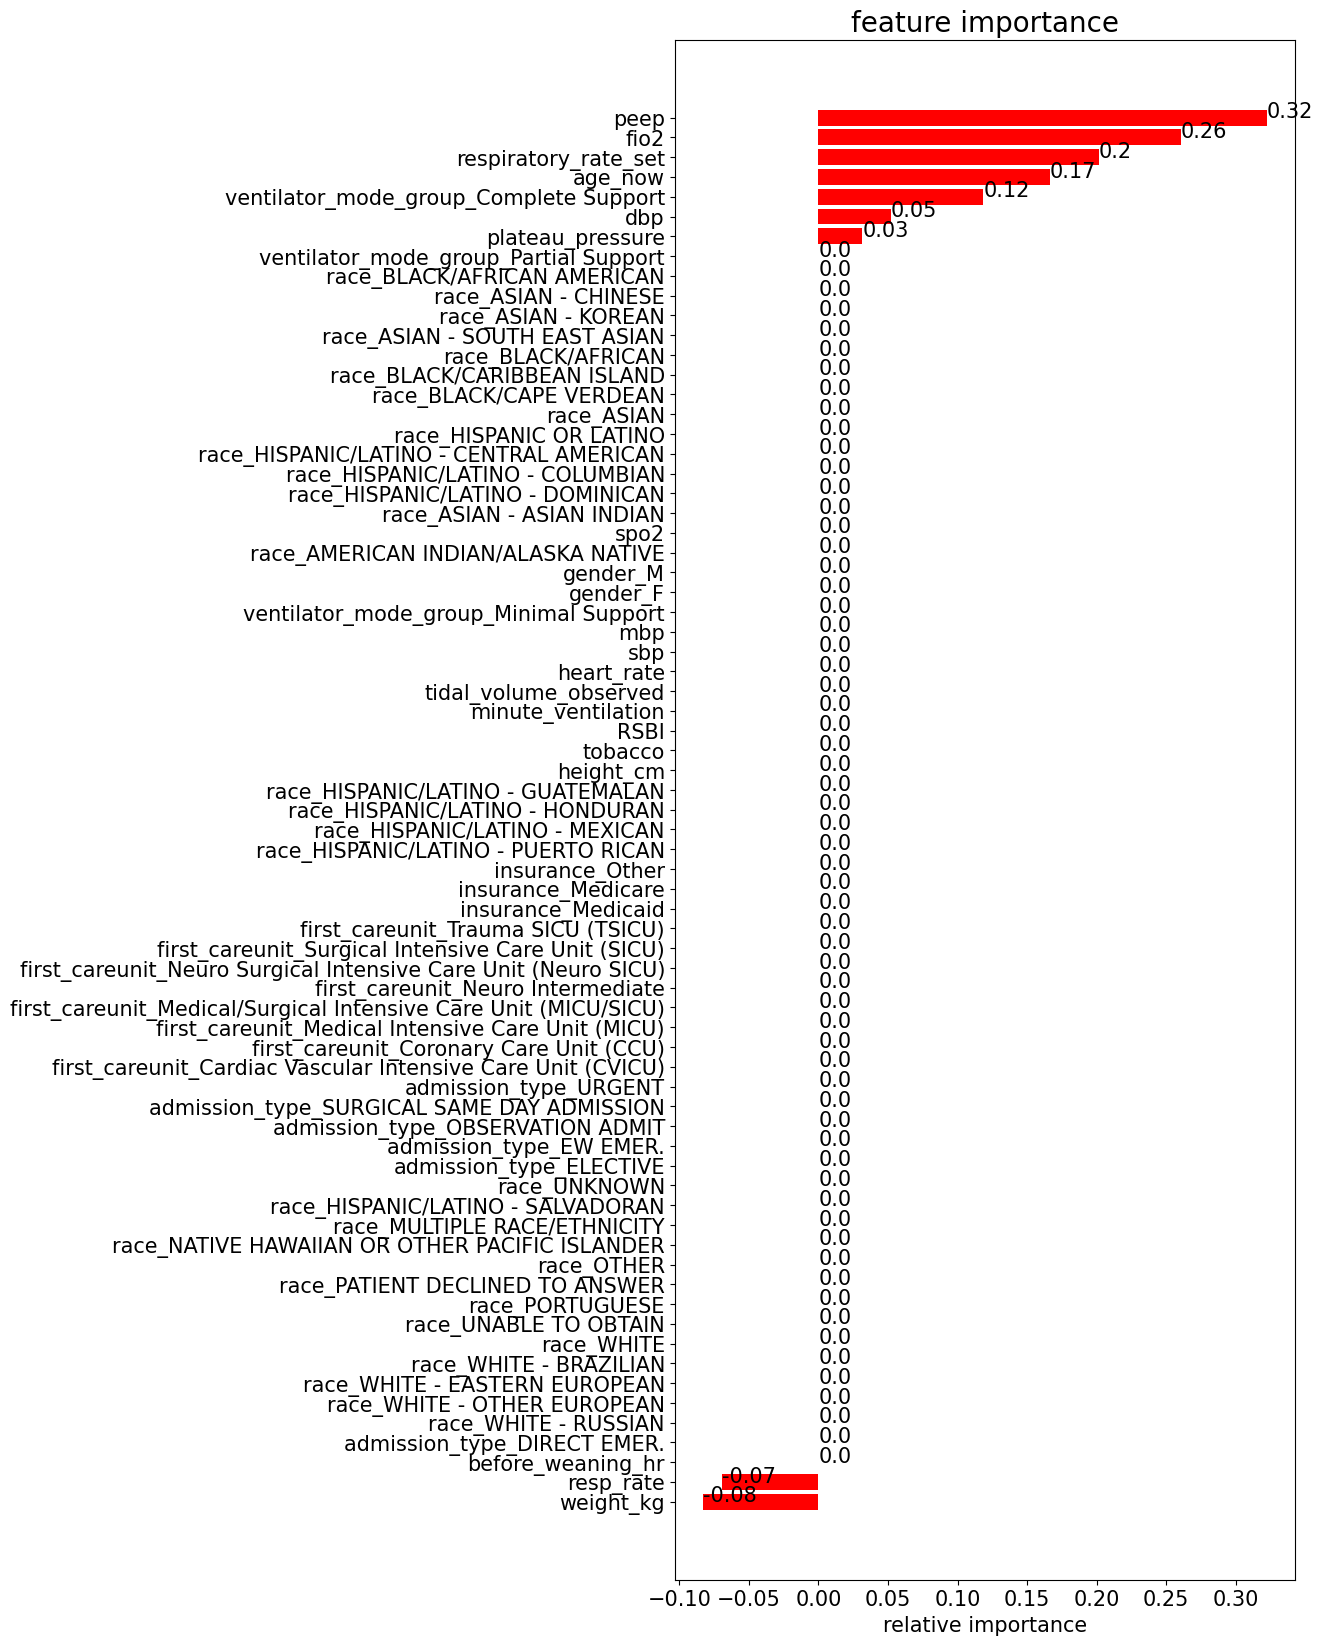

In [30]:
# step 4.1
# decision tree feature importance
dt_importance = decisionTreeModel.feature_importances_
# plot importance
df_dt_importance = pd.DataFrame(dt_importance, index=tr_v_X.columns, columns=['Importance'])
df_dt_importance.sort_values(by='Importance', ascending=False, inplace=True)
df_dt_importance.plot(kind='bar', figsize=(12, 6))
plt.title('decision tree feature importance')

print('using (train and validation) to compute feature_importance')
feature_importance(decisionTreeModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(decisionTreeModel, test_X, test_y)

before weaning hour = 365
test
sensitivity=recall= 0.9675373134328358
specificity 0.24287564766839378
accuracy_score 0.7026515151515151
ROC curve
roc_auc 0.6947330086398749


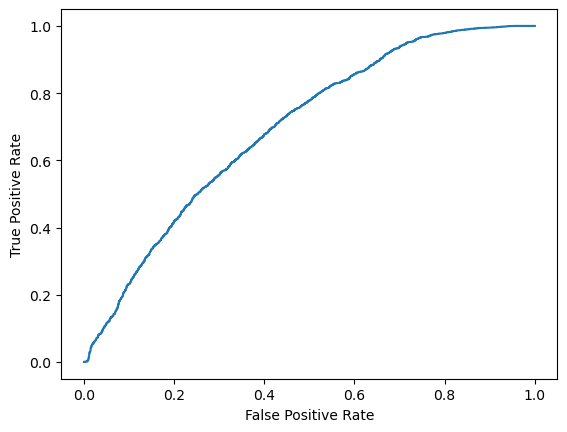

c_r
              precision    recall  f1-score   support

     class 0       0.81      0.24      0.37      4632
     class 1       0.69      0.97      0.81      8040

    accuracy                           0.70     12672
   macro avg       0.75      0.61      0.59     12672
weighted avg       0.73      0.70      0.65     12672



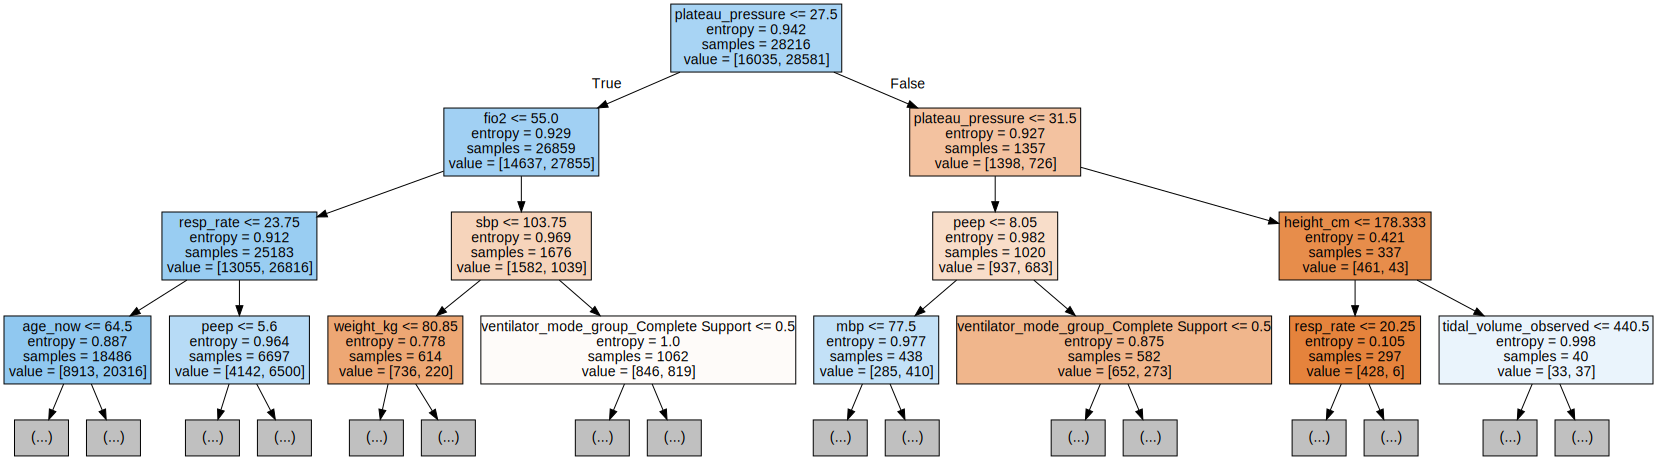

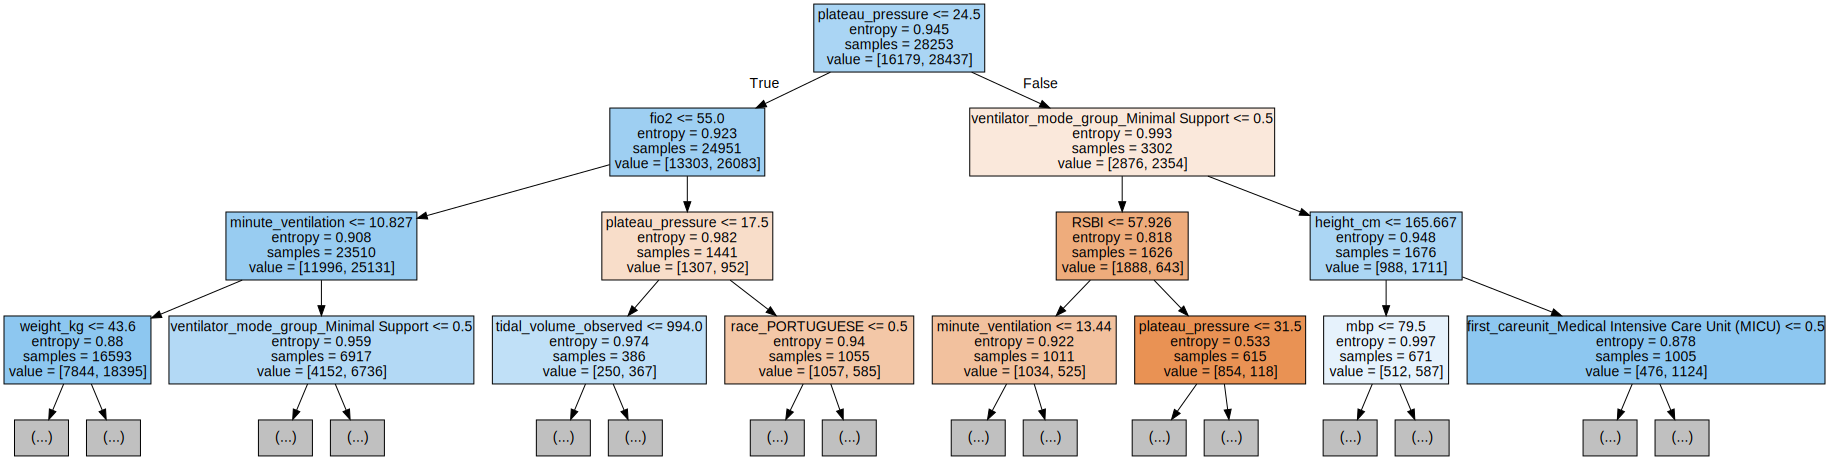

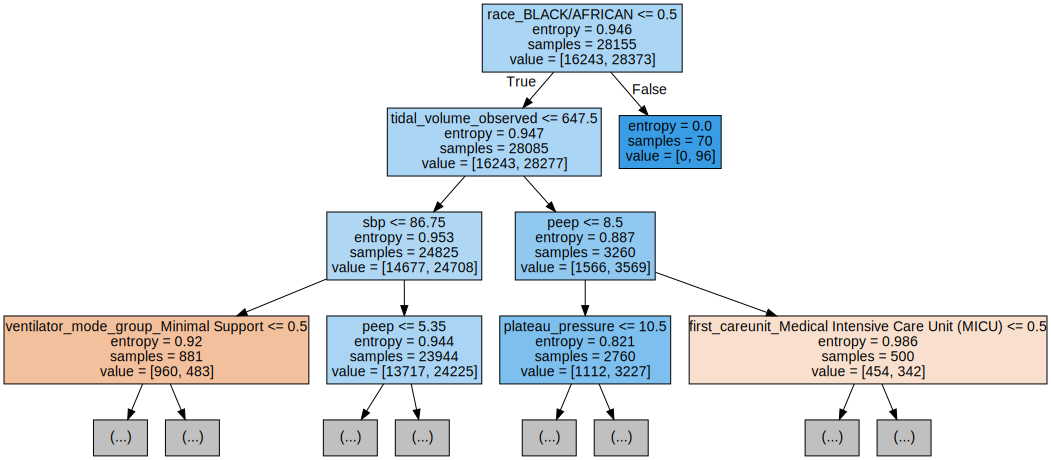

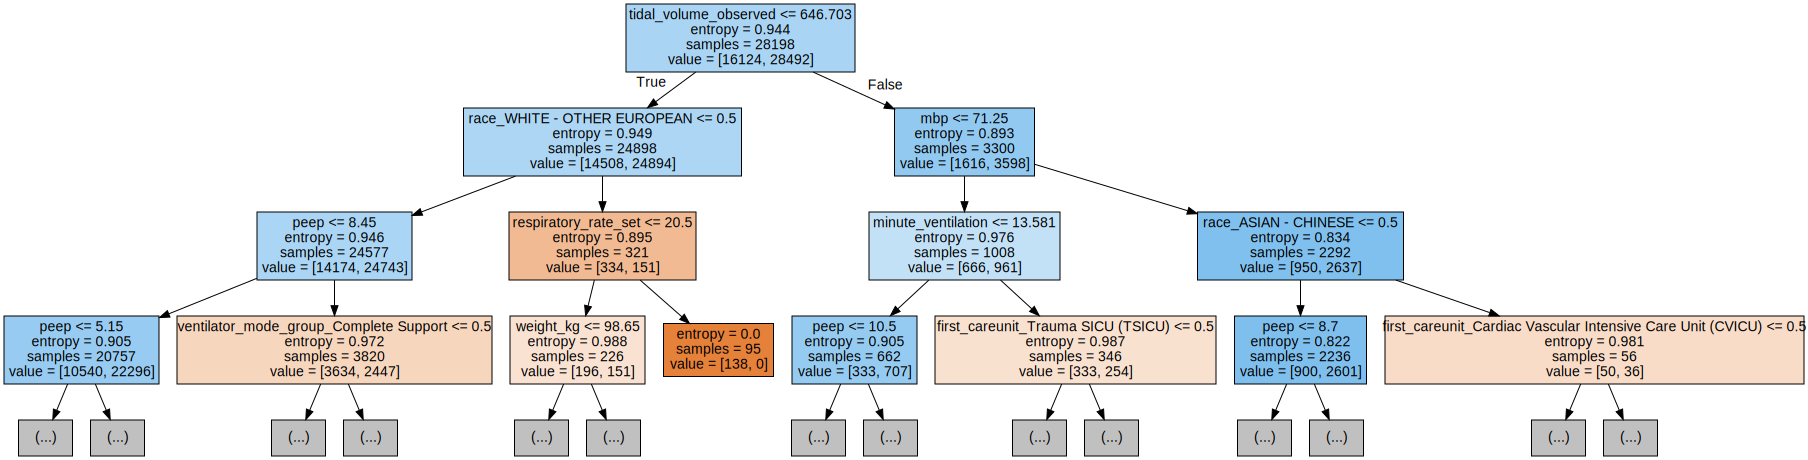

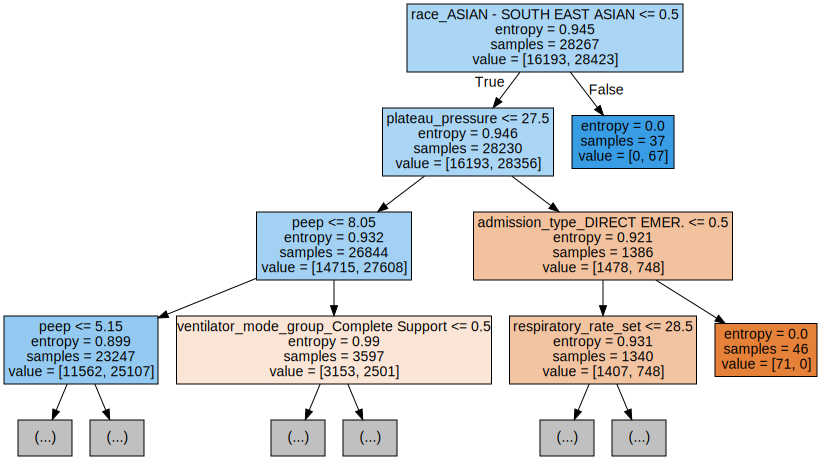

using (train and validation) to compute feature_importance


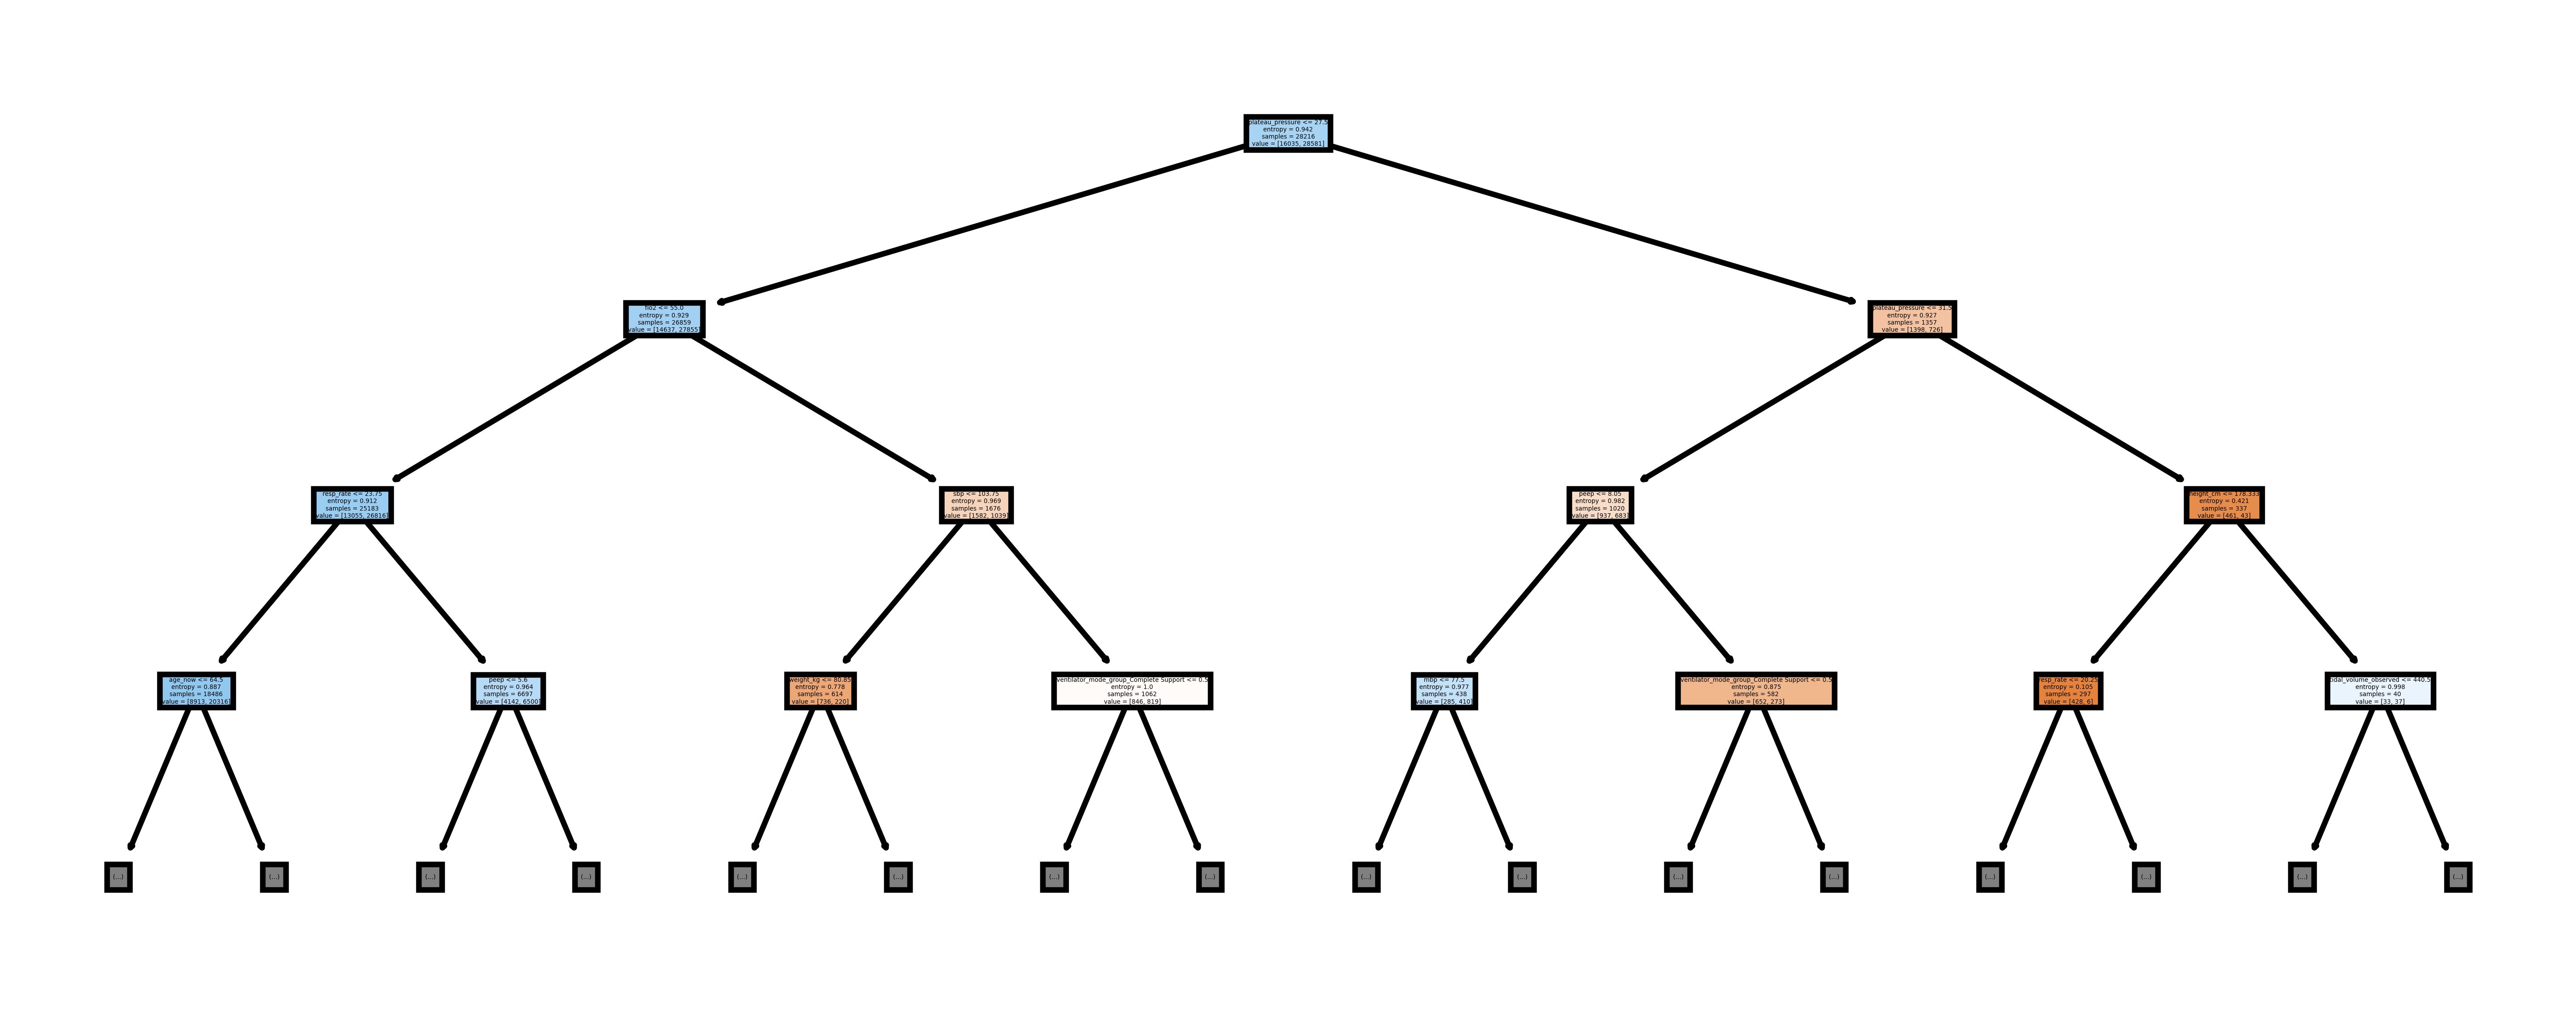

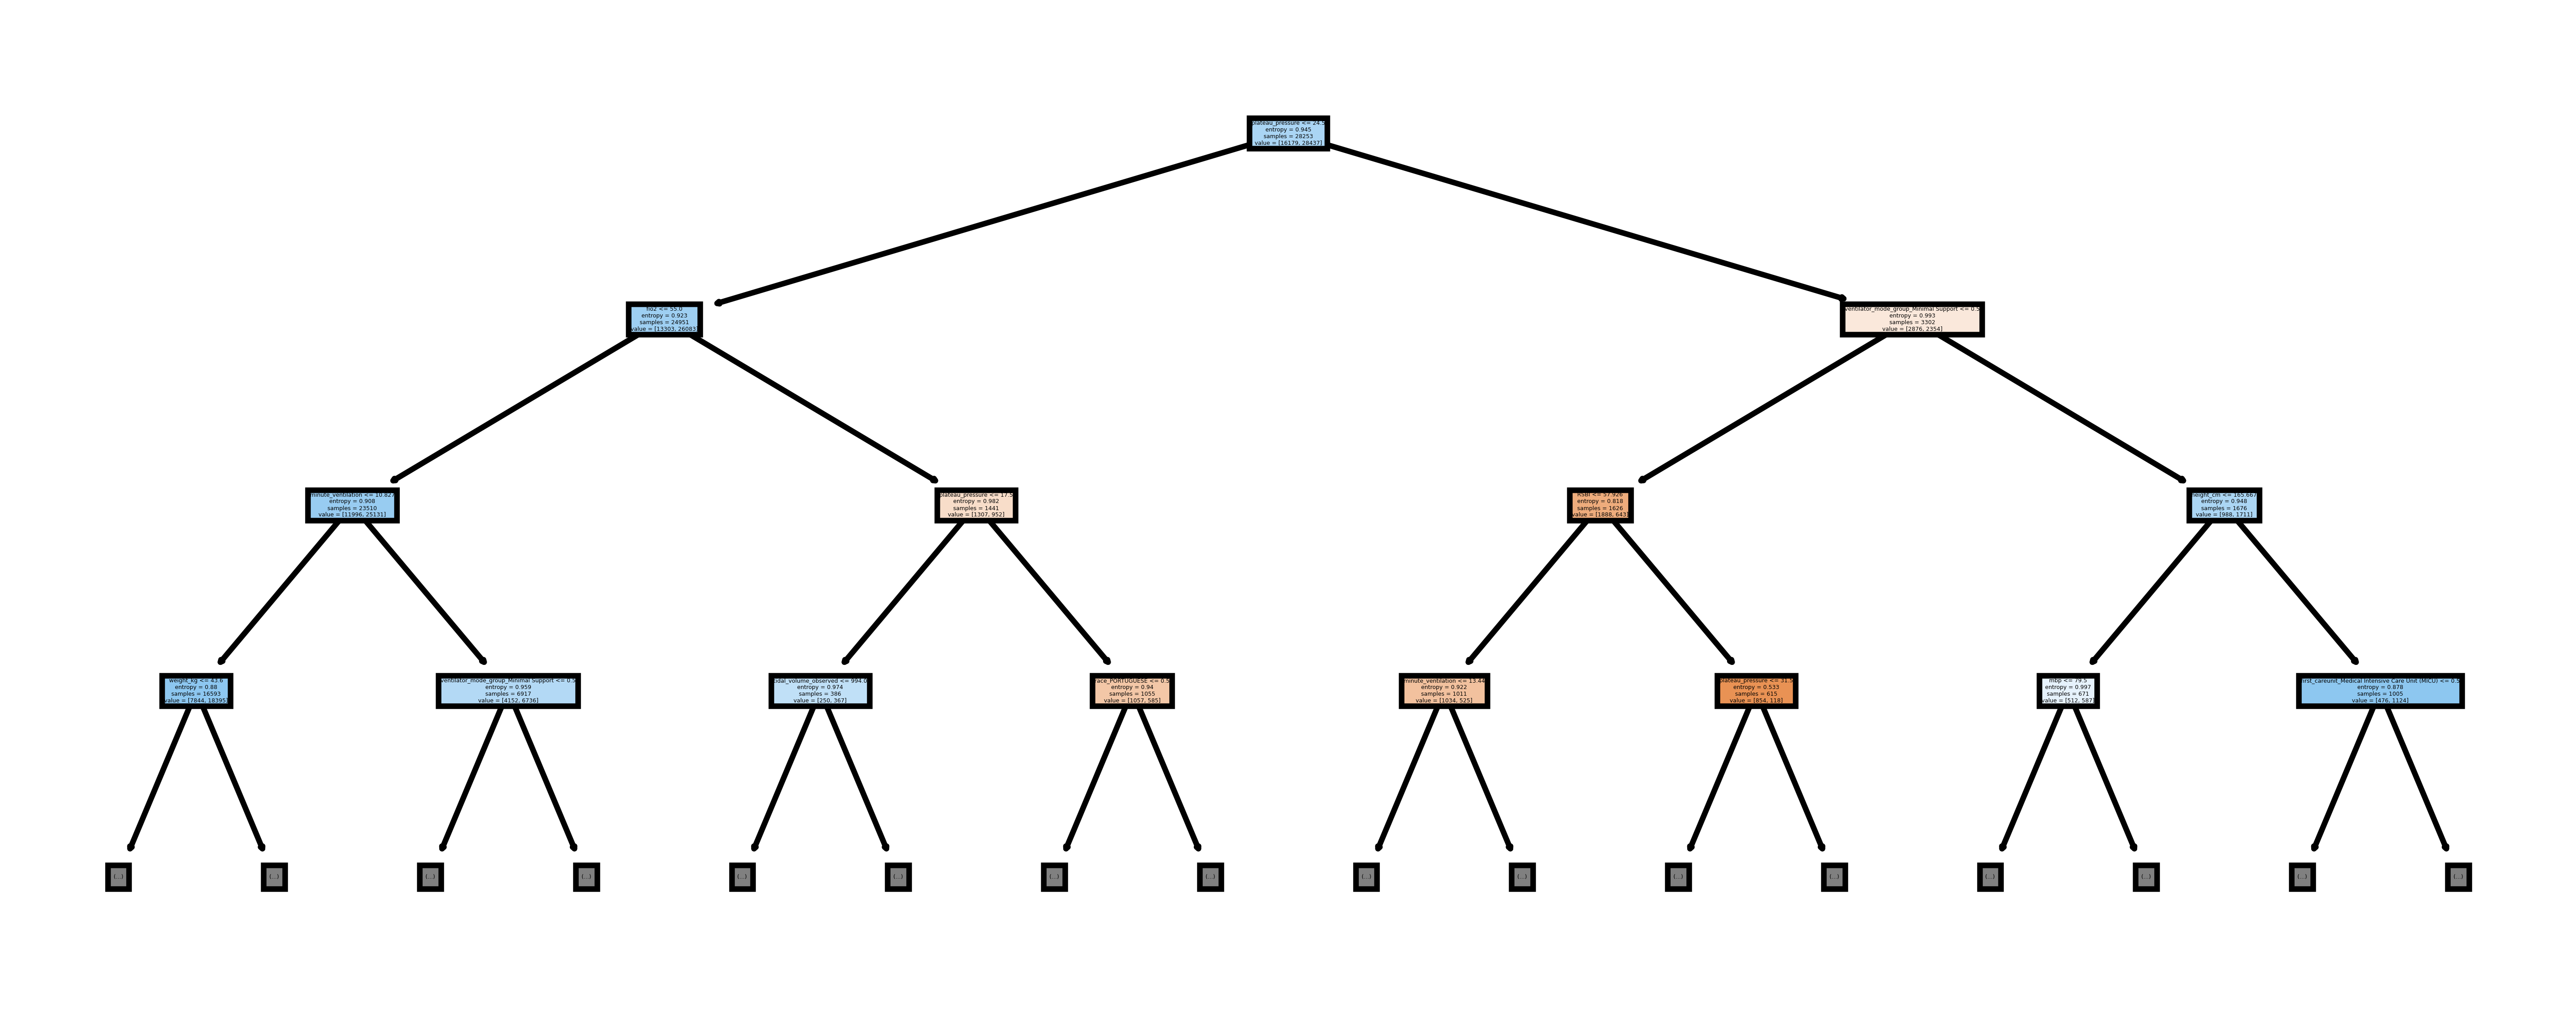

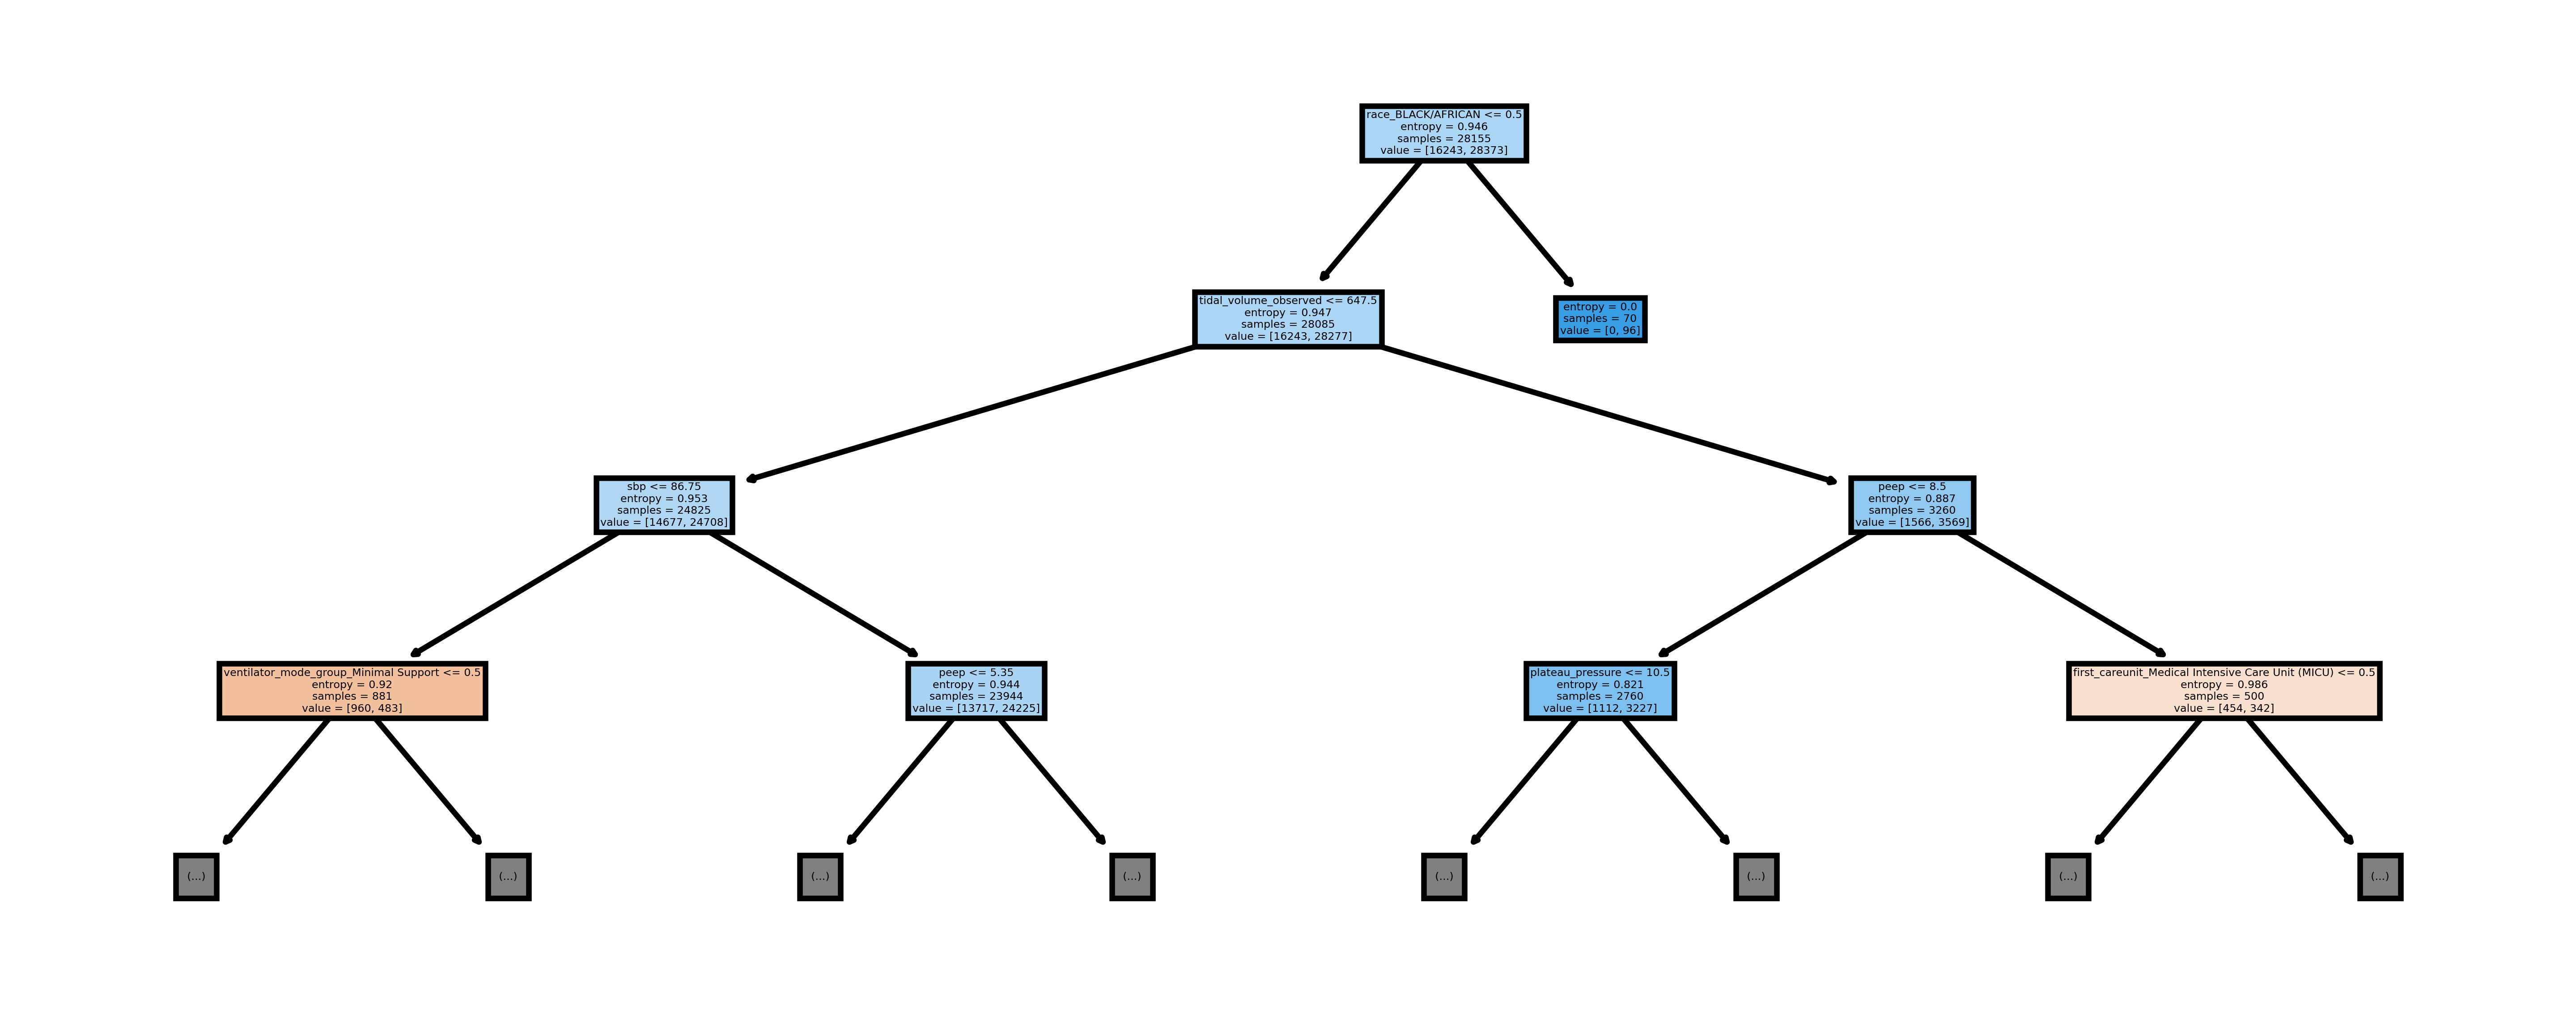

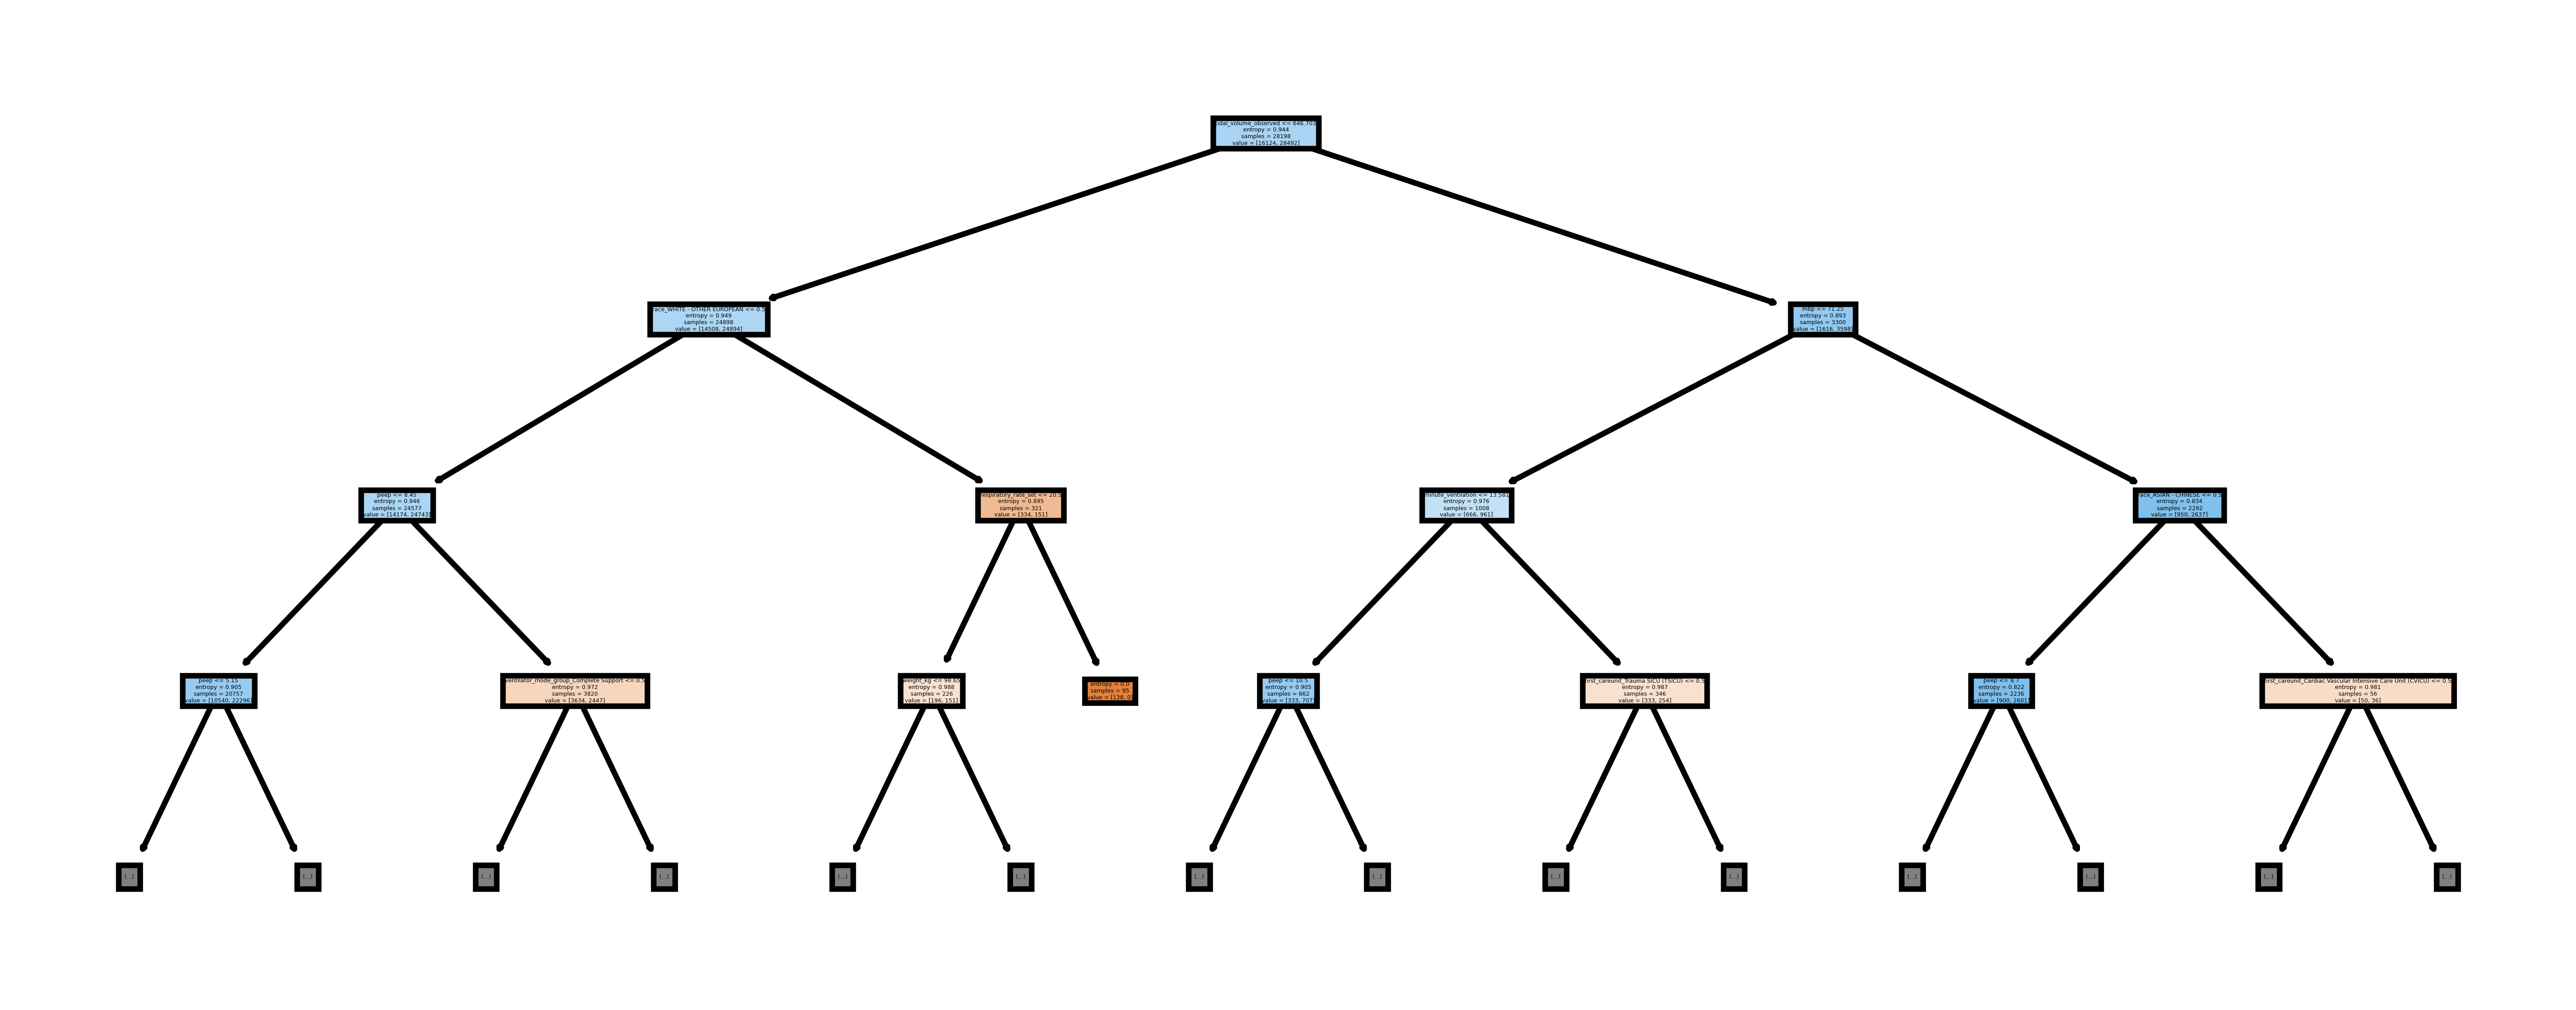

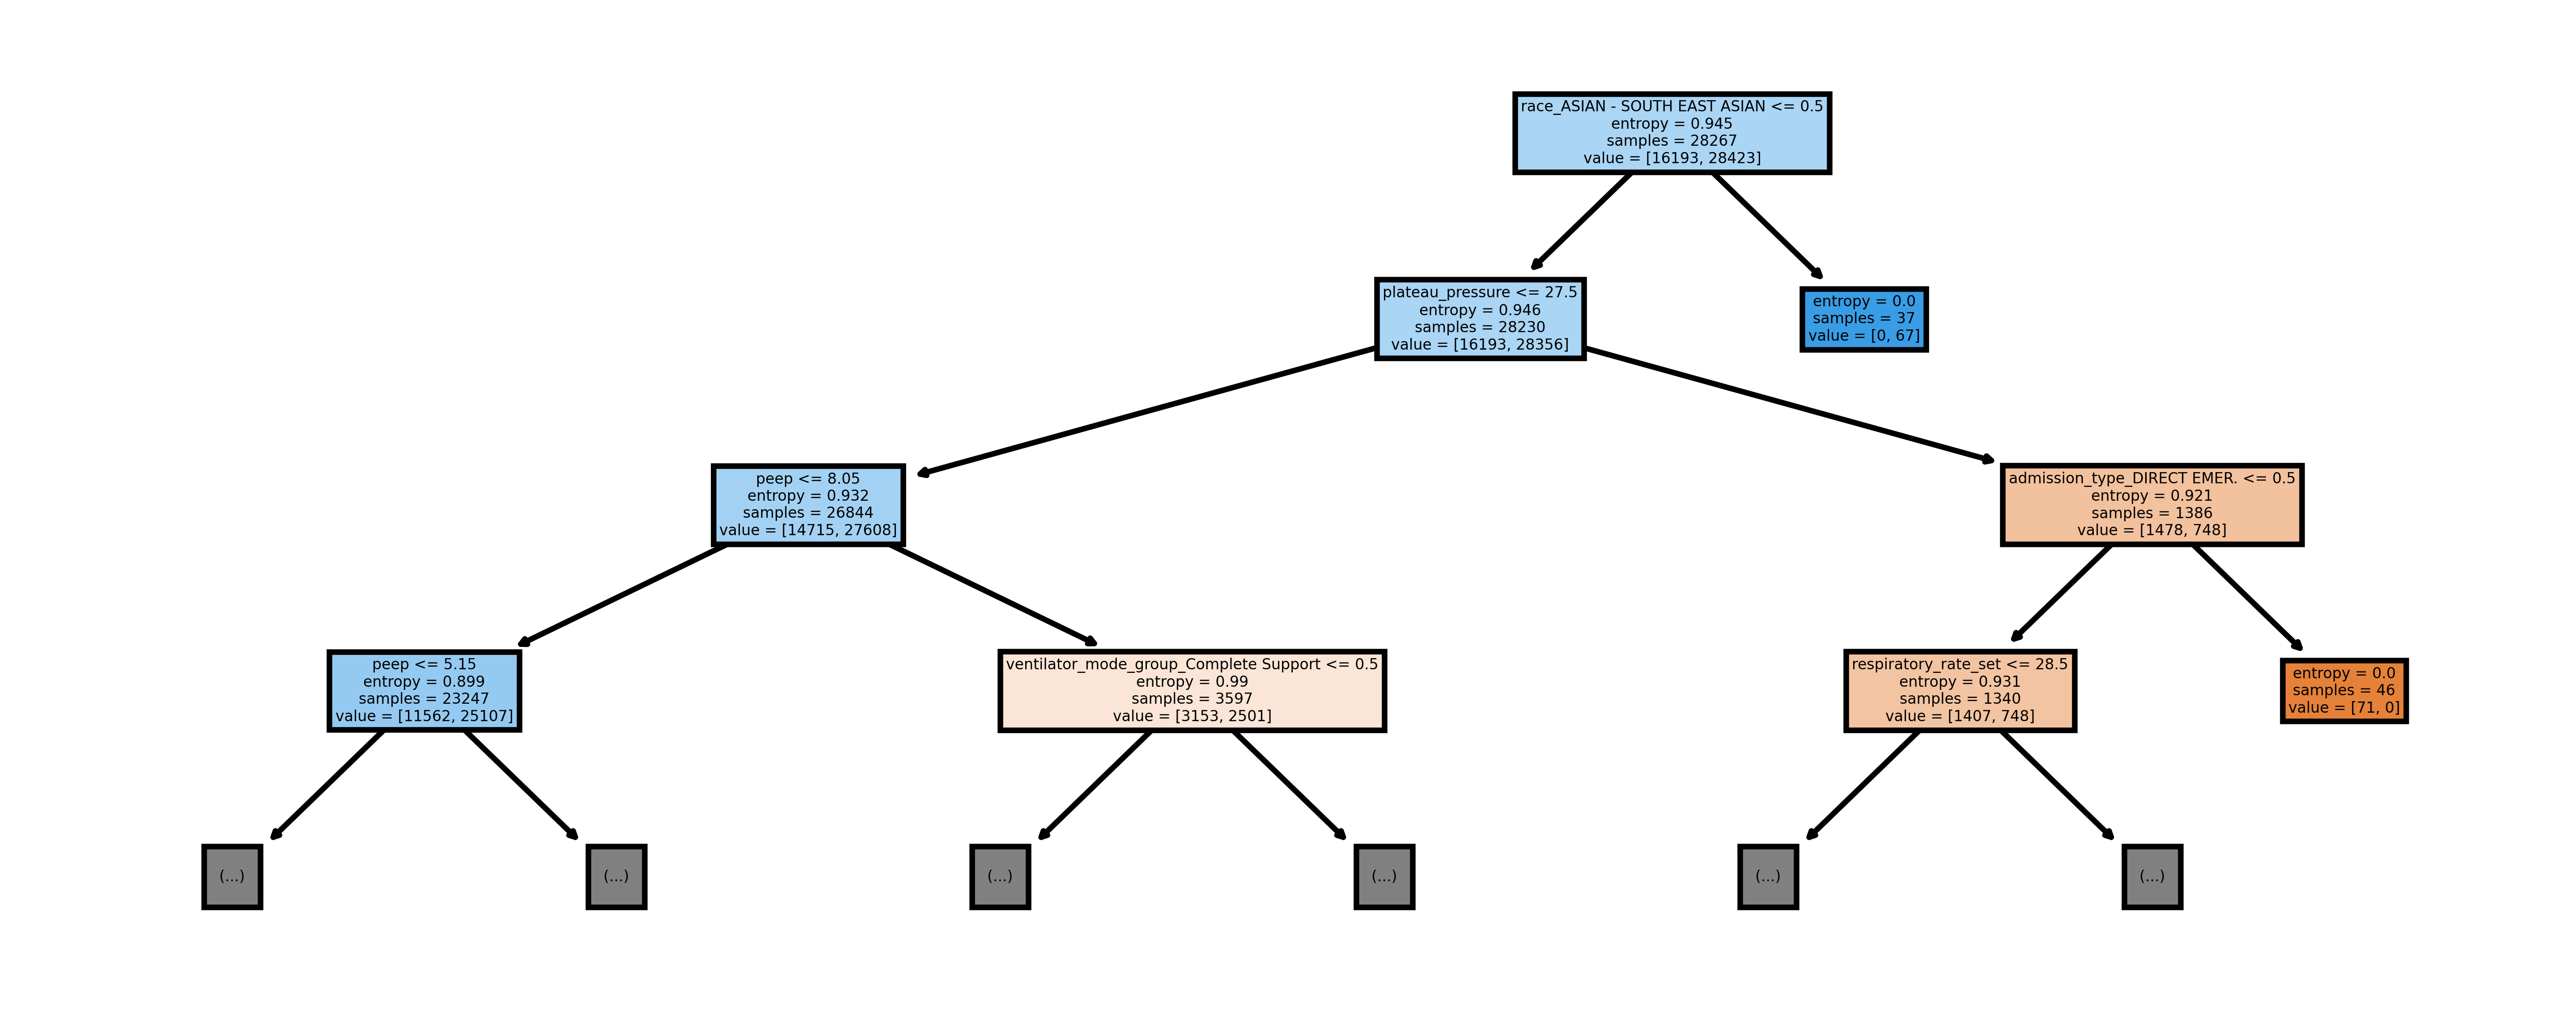

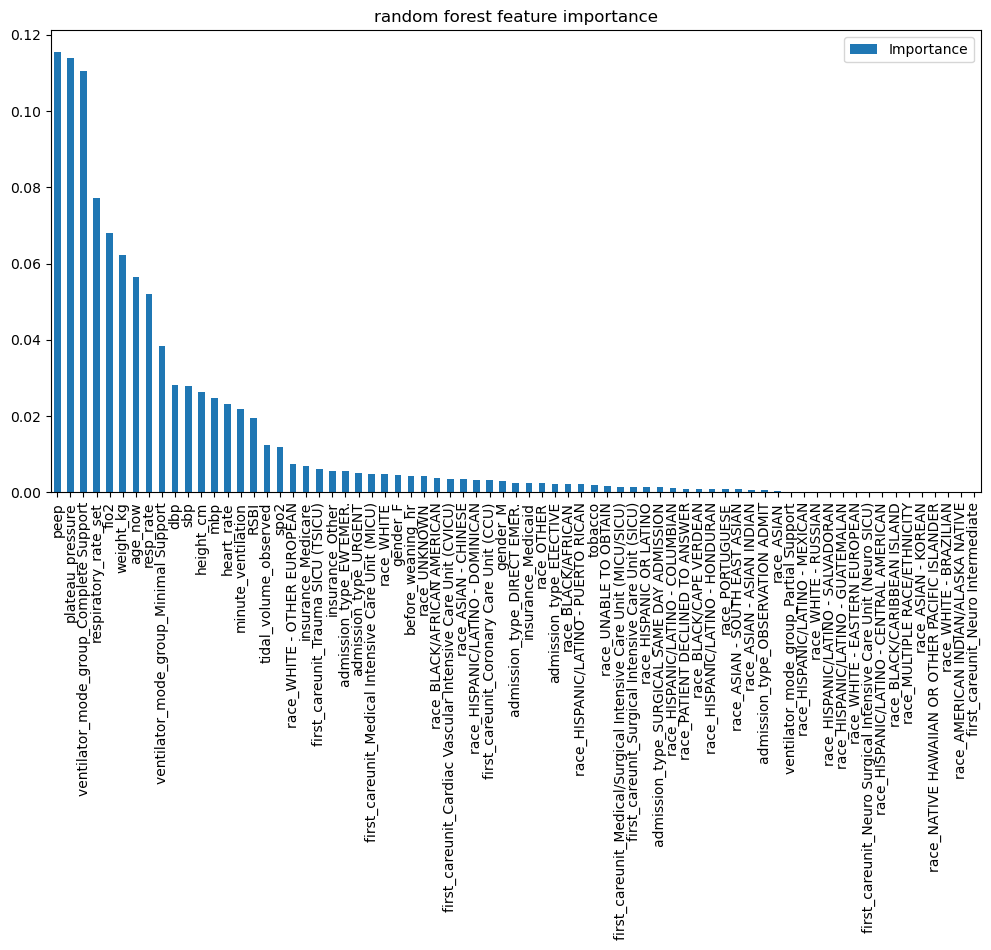

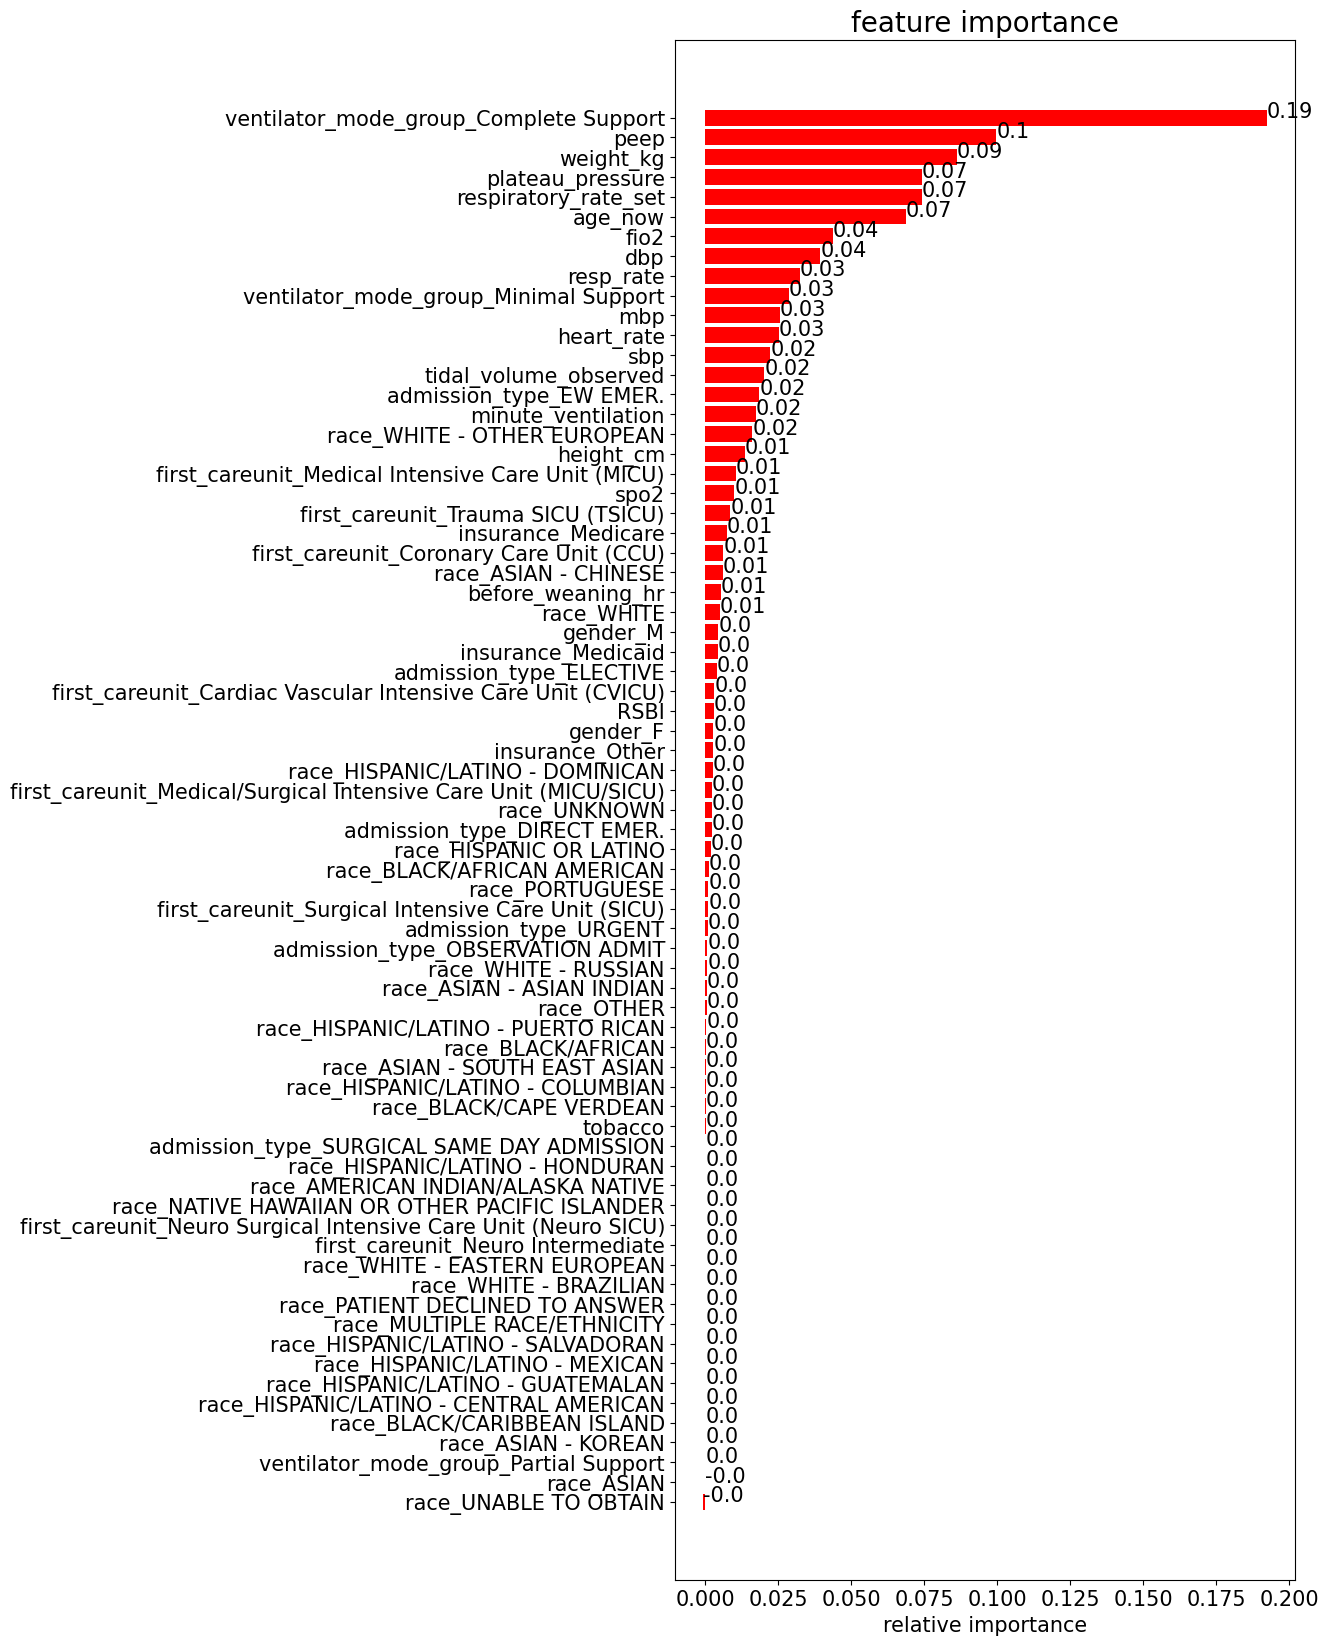

using test to compute feature_importance


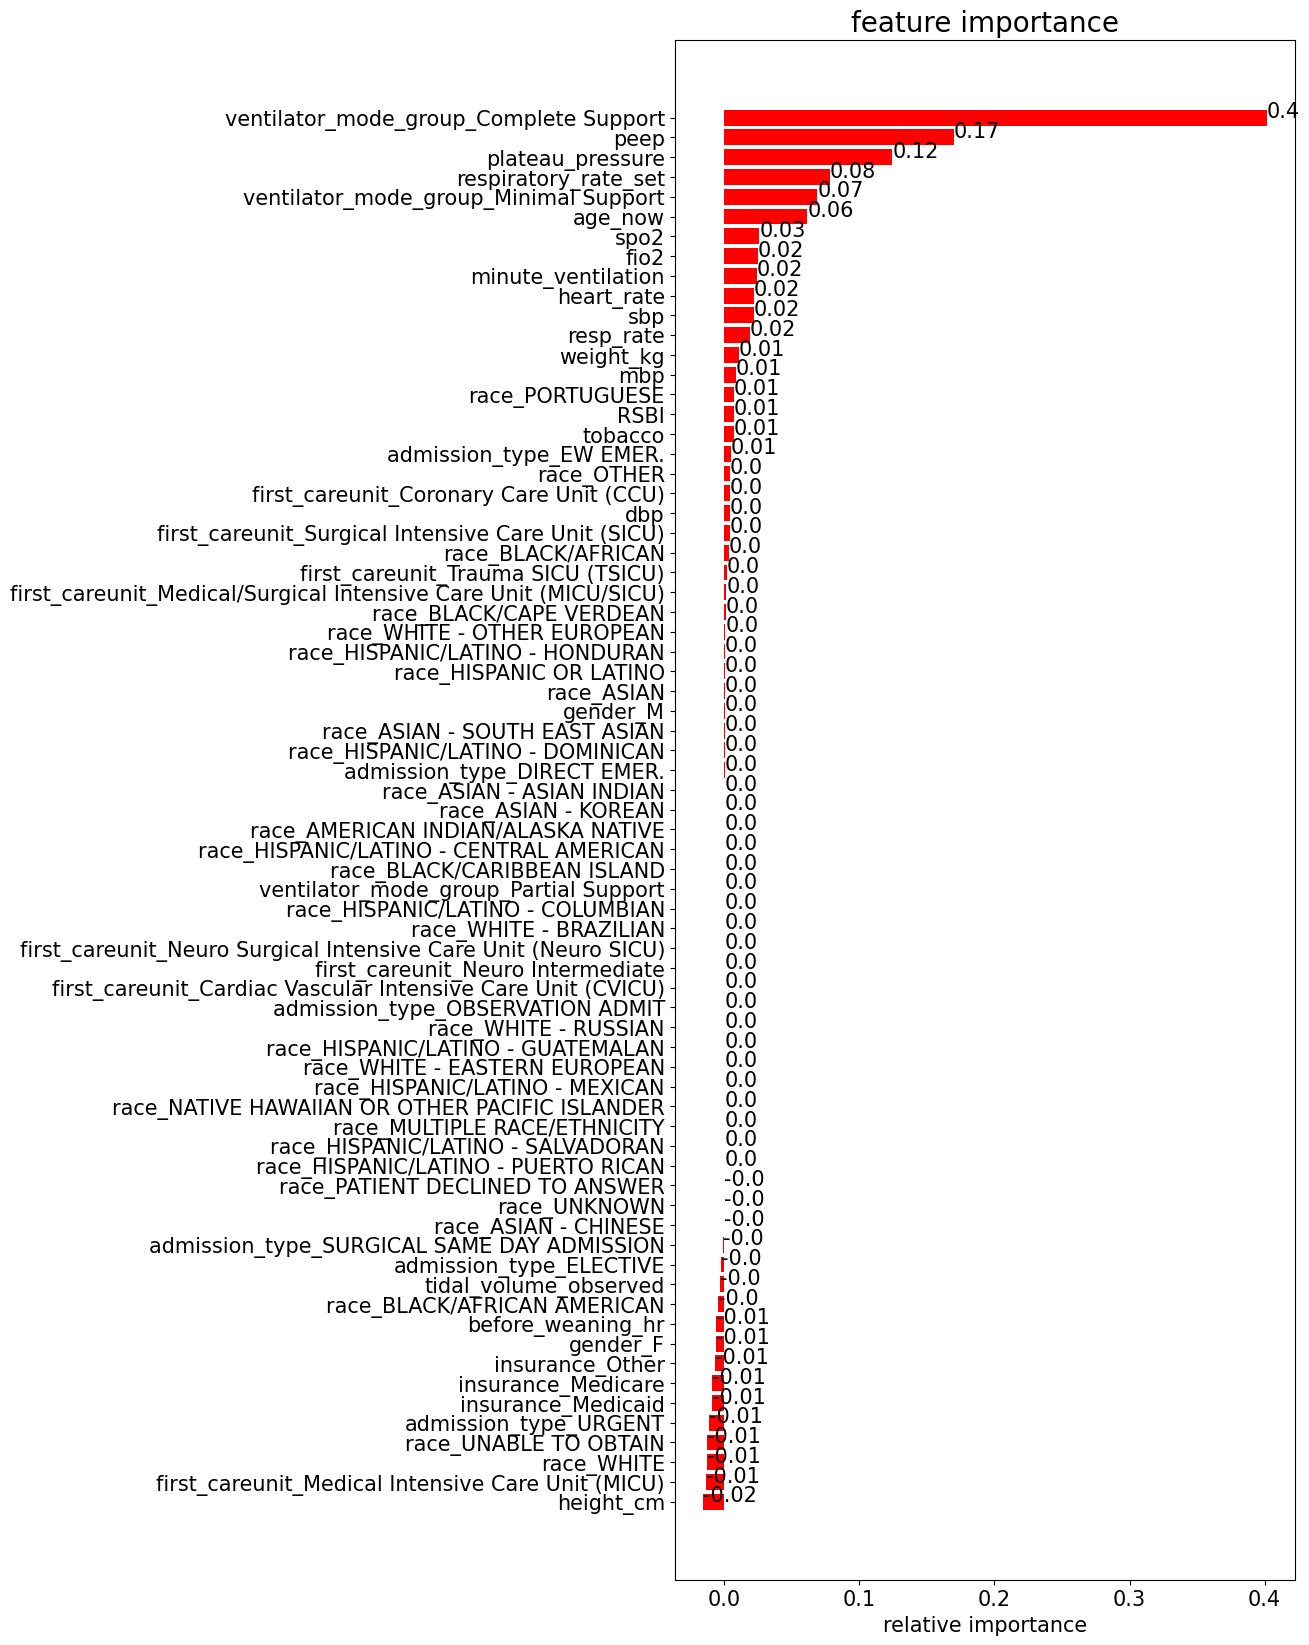

In [12]:
# step4 random forest
from sklearn.ensemble import RandomForestClassifier
tree_num = 5
from sklearn.model_selection import GridSearchCV
randomforestModel = RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=13, random_state=42) #(n_estimators=tree_num, criterion='gini', max_depth=10, min_samples_split=5)

"""param_grid = {'n_estimators':np.arange(1, 20), 'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':np.arange(1, 20), 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='accuracy', error_score='raise')
#grid_search.fit(train_X, train_y)
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
randomforestModel = grid_search.best_estimator_
"""
# 使用訓練資料訓練模型
randomforestModel.fit(train_X, train_y)
#print(m.best_estimator_)
# 使用訓練資料預測

print("before weaning hour =", print_before_weaning_hr)


# 使用訓練資料預測
"""
# accuracy for tr&v
print("train & v")
acc_function(randomforestModel, tr_v_X, tr_v_y)
"""
# accuracy for test
print("test")
acc_function(randomforestModel, test_X, test_y)


# draw tree in forest
#io = StringIO()
#fig, axes = plt.subplots(nrows=tree_num, ncols=3, figsize=(10, 2), dpi=900)
for i in range(tree_num):
    tree_of_rf = randomforestModel.estimators_[i]
    data = export_graphviz(tree_of_rf, feature_names=train_X.columns, max_depth=3, filled=True)
    graph = graphviz.Source(data)
    display(graph)
    figtmp, axestmp = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), dpi=900)
    tree.plot_tree(tree_of_rf, feature_names=train_X.columns, max_depth=3, filled=True)
    #figtmp.set_title('Estimator: '+str(i))#, fontsize=8)
    figtmp.savefig('rf_tmp'+str(i)+'.jpg')


# feature importance
rf_importance = randomforestModel.feature_importances_
# plot importance
df_rf_importance = pd.DataFrame(rf_importance, index=tr_v_X.columns, columns=['Importance'])
df_rf_importance.sort_values(by='Importance', ascending=False, inplace=True)
df_rf_importance.plot(kind='bar', figsize=(12, 6))
plt.title('random forest feature importance')

print('using (train and validation) to compute feature_importance')
feature_importance(randomforestModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(randomforestModel, test_X, test_y)

In [ ]:
# step4 SVM

# param_grid = {'C':np.linspace(1, 3, 3, endpoint=True), 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'random_state':[42]} ->get {C=2, 'kernel'='linear'}
print("before weaning hour =",print_before_weaning_hr)

from sklearn.svm import SVC

# SVM with all features
from sklearn.model_selection import GridSearchCV

Model = SVC() #(C=1, kernel=linear, probability=True, random_state=42)
param_grid = {'C':np.linspace(1, 3, 3, endpoint=True), 'kernel':('linear', 'poly'),'probability':[True], 'random_state':[42]} #, 'rbf', 'sigmoid'
#param_grid = {'C':[1], 'kernel':['linear'],'probability':[True], 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='accuracy', error_score='raise')
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
svmModel = grid_search.best_estimator_


"""
svmModel = SVC(C=1, kernel='linear', probability=True, random_state=42)
svmModel.fit(tr_v_X, tr_v_y)
"""

# accuracy for tr&v
print("train & v")
acc_function(svnModel, tr_v_X, tr_v_y)

# accuracy for test
print("test")
acc_function(svmModel, test_X, test_y)

print('using (train and validation) to compute feature_importance')
feature_importance(svmModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(svmModel, test_X, test_y)

before weaning hour = 365


In [ ]:
#step4 XGBoost
import xgboost as xgb

print("before weaning hour =", print_before_weaning_hr)
Model = xgb.XGBClassifier()
from sklearn.model_selection import GridSearchCV
param_grid =  {'n_estimators':np.arange(7, 20), 'max_depth':np.arange(1, 15), 'min_child_weight':np.arange(1, 16),  'random_state':[42]} #,'subsample':[0.6, 0.7, 0.8],'subsample':[0.5, 0.7, 0.8, 1], 'colsample_bytree':[0.5, 0.7, 0.8, 1]}#,'subsample':[0.5, 0.7, 0.8, 1], 'colsample_bytree':[0.5, 0.7, 0.8, 1]}
#param_grid = {'C':[2], 'kernel':['linear'], 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='accuracy', error_score='raise')
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
xgbModel = grid_search.best_estimator_

xgbModel.fit(tr_v_X, tr_v_y)

# accuracy for tr&v
print("train & v")
acc_function(xgbModel, tr_v_X, tr_v_y)

# accuracy for test
print("test")
acc_function(xgbModel, test_X, test_y)

# feature importance
xgb_importance = xgbModel.feature_importances_
# plot importance
df_xgb_importance = pd.DataFrame(xgb_importance, index=tr_v_X.columns, columns=['Importance'])
df_xgb_importance.sort_values(by='Importance', ascending=False, inplace=True)
df_xgb_importance.plot(kind='bar', figsize=(12, 6))
plt.title('XGBoost feature importance')

print('using (train and validation) to compute feature_importance')
feature_importance(xgbModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(xgbModel, test_X, test_y)

before weaning hour = 365


In [19]:
print((df_with_one_hot_encoding_drop_not_num.columns))
print((df.columns))

Index(['stay_id', 'age_now', 'weight_kg', 'height_cm', 'tobacco', 'RSBI',
       'minute_ventilation', 'peep', 'fio2', 'tidal_volume_observed',
       'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp',
       'mbp', 'resp_rate', 'spo2', 'label', 'gender_F', 'gender_M',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN',
       'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN',
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',
       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
       'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - DOMINICAN',
       'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - HONDURAN',
       'race_HISPANIC/LATINO - MEXICAN', 'race_HISPANIC/LATINO - PUERTO RICAN',
       'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY',
       'rac

In [26]:
# split data
label_path = './pre_24_merged_30_rows_12_07.csv'
flag_data_path = './ground_truth.csv'
raw_data_path = './pre_24_merged_30_rows_12_07.csv'

aug_columns = ['spo2','peep','heart_rate','respiratory_rate_set','plateau_pressure','tidal_volume_observed','fio2','O2_flow','sbp','dbp','mbp','resp_rate','RSBI','minute_ventilation']
#data_df = pd.read_csv(raw_data_path)
flag_data_df = pd.read_csv(flag_data_path)
label_df = pd.read_csv(label_path)

def check_missing_values(df):
    
    if df.isna().any().any():
        return 1 
    else:
        return 0 
        
def get_label(id_df):
    label = 0
    if not check_missing_values(id_df):
            label = id_df['label'].iloc[0]
            return label
        
def NN_data(flag_data_df, data_df,label_df,  hour = 23):
    total_x = []
    total_y = []
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        id_df_label = label_df[label_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df):
            label = get_label(id_df_label)
            id_df = id_df.drop(columns='stay_id')
            id_df = id_df.drop(columns='label')
            id_df = id_df.drop(columns='charttime')
            #id_df = id_df.drop(columns='Rev_h')
            #id_df = id_df.drop(columns='dod_h')

            
            zero_hr_values = id_df.iloc[hour, :].values
            #zero_hr_values = generate_more_feature(id_df, aug_columns ,zero_hr_values)

            total_x.append(zero_hr_values)
            total_y.append(label)
    total_x = np.array(total_x)
    total_y = np.array(total_y).reshape(-1, 1)
    return total_x, total_y

X, y = NN_data(flag_data_df, df_with_one_hot_encoding ,label_df )

IndexError: single positional indexer is out-of-bounds

In [4]:
tr_v_X.shape[1]

67